**1**) Check out the Jupyter notebook for Chapter 8 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb. It uses the convolutional base of VGG16 for an image classification task, and also tries fine tuning. Your task: use another existing trained neural network (which is different from VGG16, such as ResNet) for the same task, and also try fine tuning. Submit your complete code, draw figures on the training/validation performance, and show the testing performance.

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

 99% 808M/812M [00:21<00:00, 37.8MB/s]
100% 812M/812M [00:22<00:00, 38.6MB/s]


In [3]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs")


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        if not dir.exists():
            os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            shutil.copyfile(src=src, dst=dst)


# Define ranges for subsets
subsets = [("train", 0, 1000), ("validation", 1000, 1500), ("test", 1500, 2500)]

# Generate subsets
for subset_name, start_index, end_index in subsets:
    make_subset(subset_name, start_index, end_index)

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import image_dataset_from_directory

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)
AUTO = tf.data.AUTOTUNE

In [6]:
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=True
)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=True
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_data = test_dataset.prefetch(buffer_size=AUTO)
train_data = train_dataset.prefetch(buffer_size=AUTO)
validation_data = validation_dataset.prefetch(buffer_size=AUTO)

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
# Ensure that the input images are preprocessed to match the expected input range for the MobileNetV2 model
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)

In [8]:
# Create the model from the pre-trained model MobileNet V2
image_shape = IMAGE_SIZE + (3,)
existing_model = tf.keras.applications.MobileNetV2(
    input_shape=image_shape, include_top=False, weights="imagenet"
)

9406464/9406464 [==============================] - 1s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_data))
feature_batch = existing_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [10]:
# Set the existing model to non-trainable
existing_model.trainable = False

# MobileNetV2 Model summary
# existing_model.summary()

In [11]:
# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Add a dense layer for classification
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


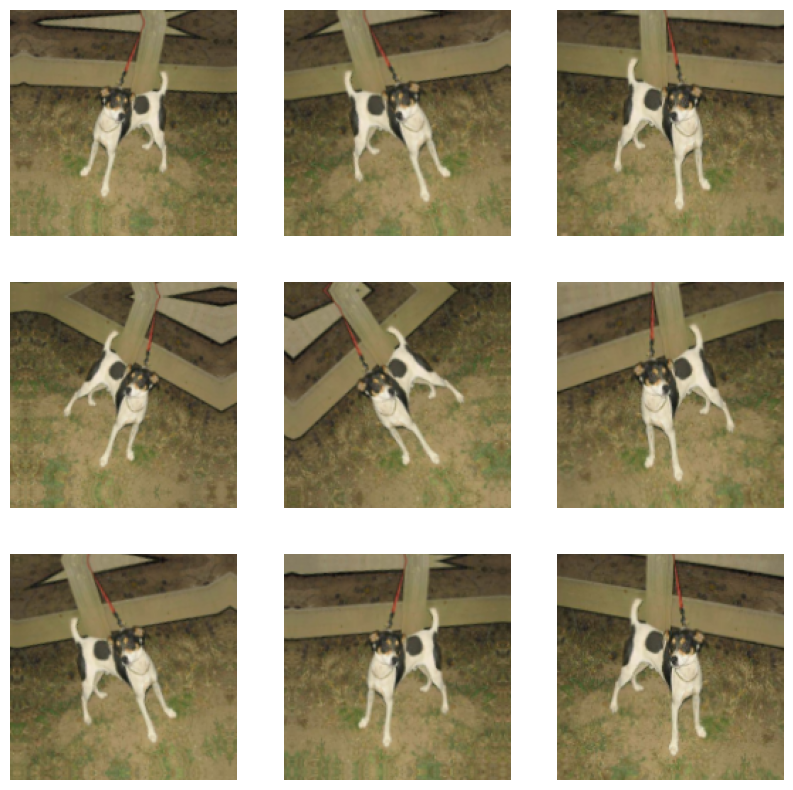

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
def get_model():
    inputs = tf.keras.Input(shape=image_shape)
    x = data_augmentation(inputs)
    x = preprocess(x)
    x = existing_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    return tf.keras.Model(inputs, outputs)


model = get_model()

# Compile the existing model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# model.summary()

In [14]:
# Initial performance when the model is not trained
init_loss, init_accuracy = model.evaluate(validation_data)
print("initial loss: {:.2f}".format(init_loss))
print("initial accuracy: {:.2f}".format(init_accuracy))

32/32 [==============================] - 10s 49ms/step - loss: 0.8849 - accuracy: 0.5080
initial loss: 0.88
initial accuracy: 0.51


In [15]:
history = model.fit(train_data, epochs=10, validation_data=validation_data, verbose=1)

Epoch 1/10
63/63 [==============================] - 11s 102ms/step - loss: 0.7492 - accuracy: 0.5560 - val_loss: 0.5524 - val_accuracy: 0.6340
Epoch 2/10
63/63 [==============================] - 4s 54ms/step - loss: 0.5412 - accuracy: 0.6770 - val_loss: 0.3918 - val_accuracy: 0.7710
Epoch 3/10
63/63 [==============================] - 4s 56ms/step - loss: 0.4087 - accuracy: 0.7760 - val_loss: 0.2969 - val_accuracy: 0.8510
Epoch 4/10
63/63 [==============================] - 5s 81ms/step - loss: 0.3312 - accuracy: 0.8375 - val_loss: 0.2400 - val_accuracy: 0.8950
Epoch 5/10
63/63 [==============================] - 6s 88ms/step - loss: 0.2959 - accuracy: 0.8690 - val_loss: 0.2010 - val_accuracy: 0.9170
Epoch 6/10
63/63 [==============================] - 4s 54ms/step - loss: 0.2522 - accuracy: 0.8920 - val_loss: 0.1754 - val_accuracy: 0.9330
Epoch 7/10
63/63 [==============================] - 6s 97ms/step - loss: 0.2320 - accuracy: 0.9055 - val_loss: 0.1558 - val_accuracy: 0.9460
Epoch 8/10


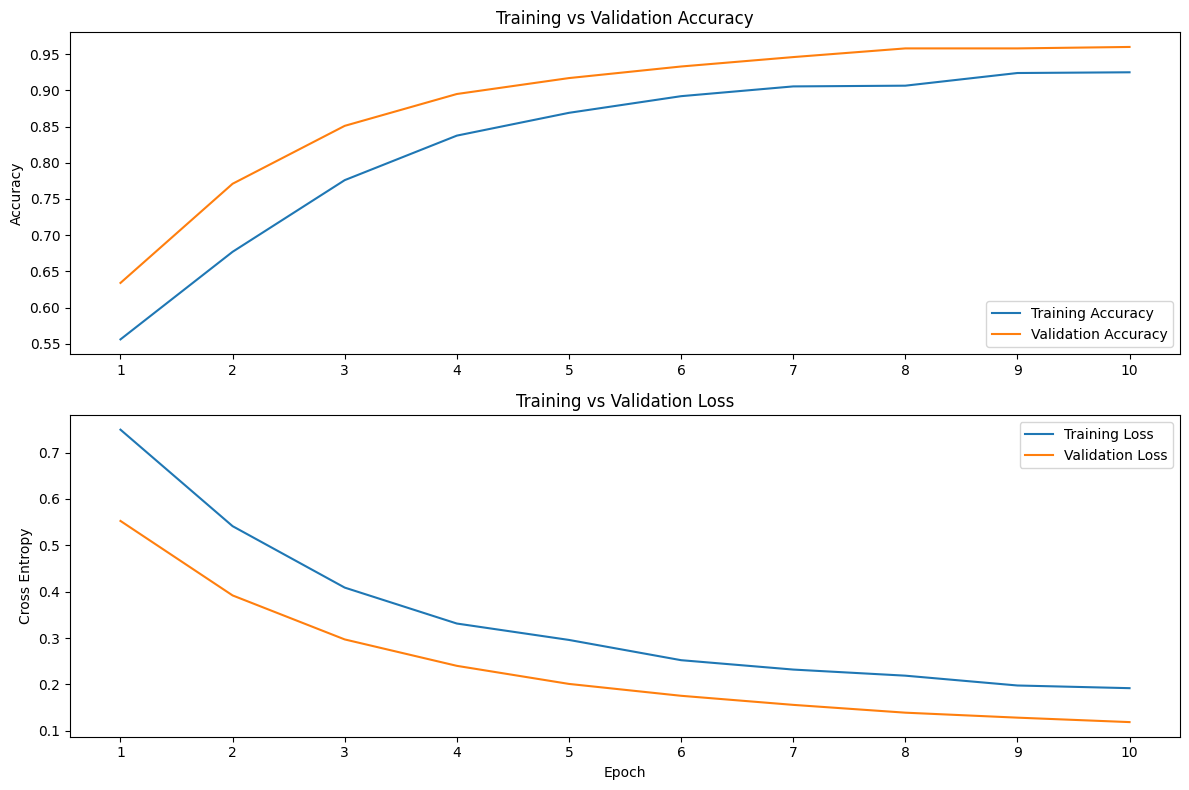

In [16]:
# Training vs Validation accuracy comparison
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xticks(epochs)

# Training loss vs Validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.xticks(epochs)

plt.tight_layout()
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

63/63 [==============================] - 3s 40ms/step - loss: 0.1291 - accuracy: 0.9450
Test loss: 0.12905824184417725
Test accuracy: 0.9449999928474426


In [18]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

Predictions:
 [0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1]
Labels:
 [0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1]


In [19]:
# Set the traning parameter to dynamic so that the model is trainable
existing_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# model.summary()

In [20]:
history_ftune = model.fit(
    train_data,
    epochs=20,
    initial_epoch=history.epoch[-1],
    validation_data=validation_data,
    verbose=1,
)

Epoch 10/20
63/63 [==============================] - 29s 151ms/step - loss: 0.1235 - accuracy: 0.9485 - val_loss: 0.0560 - val_accuracy: 0.9770
Epoch 11/20
63/63 [==============================] - 8s 123ms/step - loss: 0.0866 - accuracy: 0.9700 - val_loss: 0.0447 - val_accuracy: 0.9840
Epoch 12/20
63/63 [==============================] - 7s 104ms/step - loss: 0.0711 - accuracy: 0.9720 - val_loss: 0.0445 - val_accuracy: 0.9860
Epoch 13/20
63/63 [==============================] - 9s 134ms/step - loss: 0.0670 - accuracy: 0.9725 - val_loss: 0.0423 - val_accuracy: 0.9870
Epoch 14/20
63/63 [==============================] - 7s 103ms/step - loss: 0.0657 - accuracy: 0.9735 - val_loss: 0.0460 - val_accuracy: 0.9830
Epoch 15/20
63/63 [==============================] - 8s 126ms/step - loss: 0.0504 - accuracy: 0.9800 - val_loss: 0.0479 - val_accuracy: 0.9860
Epoch 16/20
63/63 [==============================] - 8s 127ms/step - loss: 0.0498 - accuracy: 0.9795 - val_loss: 0.0389 - val_accuracy: 0.988

In [21]:
acc += history_ftune.history["accuracy"]
val_acc += history_ftune.history["val_accuracy"]

loss += history_ftune.history["loss"]
val_loss += history_ftune.history["val_loss"]
epochs = range(1, len(acc) + 1)

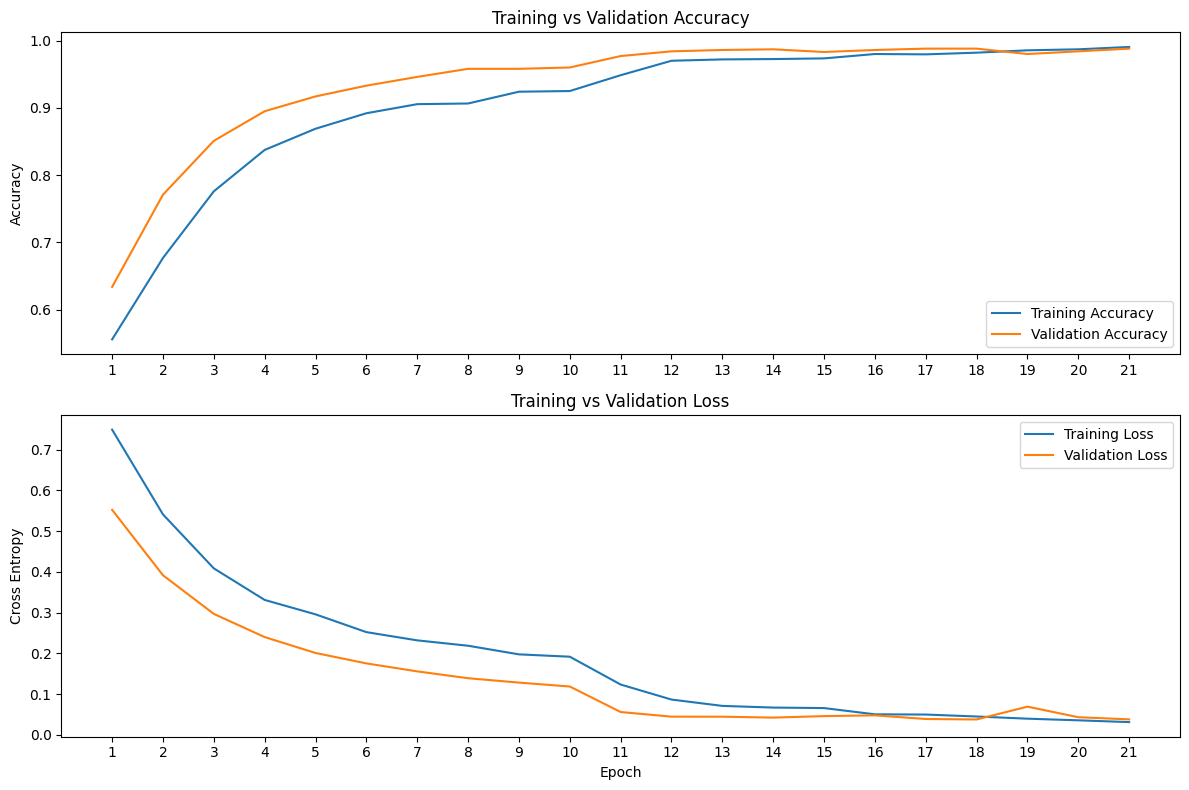

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xticks(epochs)

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.xticks(epochs)

plt.tight_layout()
plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

63/63 [==============================] - 5s 71ms/step - loss: 0.0464 - accuracy: 0.9795
Test loss: 0.04636590927839279
Test accuracy: 0.9794999957084656


In [24]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since the model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

Predictions:
 [1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0]
Labels:
 [1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0]
